# Minería de Datos (Master en Data Science, UIMP-UC)

## S17/T03. Intercomparación de técnicas de minería de datos 

### [Profesor: Rodrigo García Manzanas]    
#### Enero 2019

## Introducción

En esta práctica/tarea haremos una intercomparación de varias de las técnicas vistas a lo largo de la asignatura: CART, k-NN, GLMs y random forests. Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

Comenzaremos cargando el dataset `meteo`, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación de larga escala. Dichos predictores corresponden a un conjunto de 8 variables meteorológicas
* altura geopotencial en 500 hPa
* temperatura del aire en 850 hPa, 700 hPa, 500 hPa y superficie
* humedad específica del aire en 850 hPa y 500 hPa
* presión a nivel del mar

definidas sobre un dominio geográfico que incluye 40 puntos sobre la península Ibérica.

In [1]:
#::GMG::Limpo todas las variables de memoria y cargo los datos del Github de SantanderMetGroup
## loading data
rm(list = ls())
meteo <- read.csv(url(
    'https://raw.githubusercontent.com/SantanderMetGroup/Master-Data-Science/master/Data_mining/datasets/meteo.csv')
)

In [2]:
#::GMG::Elimino la variable no informativa X
meteo$X <- NULL

In [3]:
#::GMG::Tengo el dataset completo (y + Xn ...)
head(x = meteo,n = 5)

y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320
10.9,57042.96,56534.84,55884.40,55175.59,54458.21,56980.27,56460.59,55800.02,55051.15,⋯,101985.9,101627.3,101357.2,101110.7,101291.0,101814.9,101479.4,101164.5,100970.7,100905.3
0.6,56963.20,56493.45,55930.82,55340.20,54768.63,56856.57,56361.95,55776.76,55164.26,⋯,102048.1,102069.7,102204.5,102480.3,102858.8,101973.3,102033.3,102165.5,102323.9,102534.2
13.0,56522.59,55971.40,55304.34,54498.03,53725.15,56514.84,55977.71,55327.28,54569.78,⋯,102399.1,102448.4,102438.3,102434.3,102339.8,102669.7,102565.5,102530.3,102453.6,102487.1
0.0,54627.98,53979.80,53494.05,53072.98,52616.36,54776.17,54089.05,53516.98,53012.86,⋯,100970.0,100672.8,100360.7,100133.7,100028.4,101126.2,100700.0,100381.3,100118.3,100319.8
0.0,53584.38,53391.01,53310.38,53292.82,53340.13,53781.70,53498.13,53306.82,53213.26,⋯,100652.7,100663.5,100747.7,100934.0,101015.8,100801.6,100685.3,100777.5,100909.4,101164.7


Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad de nuetro problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La idea es que, cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes.
Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

In [4]:
#::GMG::Aplico una selección de predictores basada en la correlación de los mismos con
#       la precipitación (variable objetivo)
### informed selection of predictors, based on a correlation analysis ###
# https://stats.stackexchange.com/questions/138860/is-using-correlation-matrix-to-select-predictors-for-regression-correct
# https://www.researchgate.net/post/Should_we_select_predicting_variables_simply_with_their_correlation_with_the_dependent_variable
# https://www.researchgate.net/post/How_to_refine_MaxEnt_model_by_removing_variables_that_are_highly_correlated
r.xy <- c()
for (ivar in 2:ncol(meteo)) {
  r.xy[ivar] <- cor(meteo$y, meteo[, ivar], method = "spearman")
}

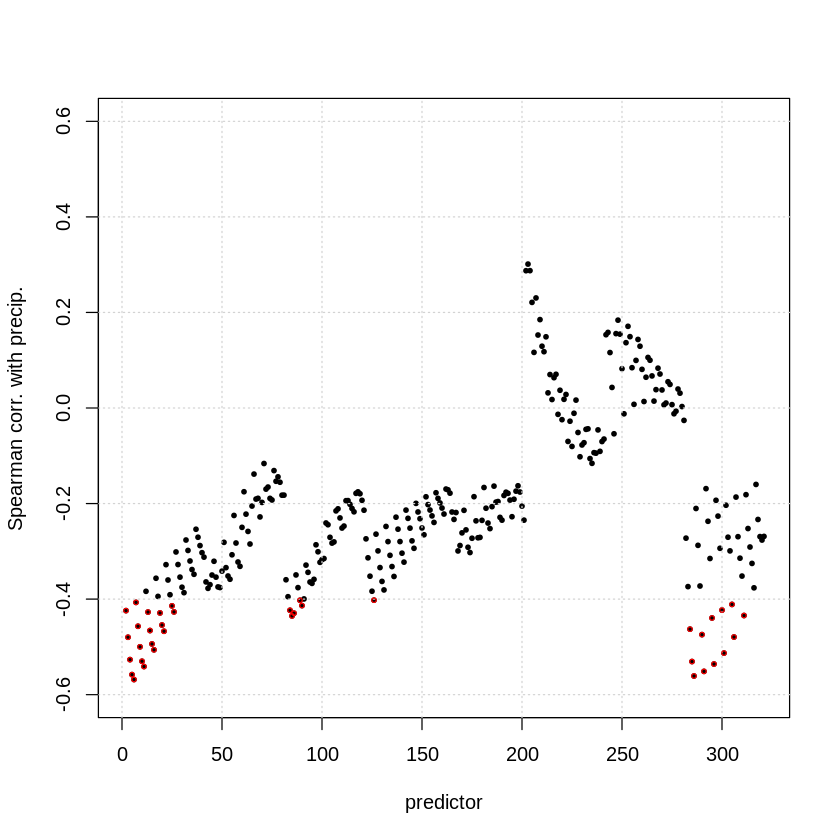

In [5]:
#::GMG::Dibujo las correlaciones de los predictores con y
plot(r.xy, 
     ylim = c(-0.6, 0.6), 
     pch = 19, cex = 0.5, 
     xlab = "predictor", 
     ylab = "Spearman corr. with precip.")
grid()
#::GMG::Hago la selección con un umbral
ind.sele <- which(abs(r.xy) > 0.4)
points(ind.sele, r.xy[ind.sele], col = "red", cex = 0.5)

In [6]:
#::GMG::Guardo el dataset (data.frame) con los predictores seleccionados
meteo_spearman <- meteo[, ind.sele]
str(meteo_spearman)

'data.frame':	10958 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

In [7]:
#::GMG::Selecciono los primeros 5000 días del dataset para simplificar cálculos
# keeping only 5000 days for this example
n <- 5000
y <- meteo$y[1:n]
x <- meteo_spearman[1:n,]
str(x)

'data.frame':	5000 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 :

In [8]:
str(y)

 num [1:5000] 10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...


In [9]:
#::GMG::Hago la partición Train/Test para Cross-Validation
#::nota::pongo un seed para reproducir los resultados entre ejecuciones
#        del R Notebook
# train/test partition
set.seed(123)
indtrain <- sample(1:n, round(0.75*n))  
indtest <- setdiff(1:n, indtrain)

## Punto 1: Árboles de clasificación y regresión (CART)
### (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia.
Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1mm) y construir el dataframe asociado al problema.

### Clasificación CART

#### Occurrence (lluvia/no lluvia)

In [10]:
#::GMG::Convierto la variable precipitación en factor con un umbral (1mm)
### binary occurrence con umbral 1 mm de precipitación ###
occurrence <- ifelse(y >= 1, 1, 0)
str(occurrence)

 num [1:5000] 1 0 1 0 0 1 1 0 0 0 ...


occurrence
   0    1 
3989 1011 

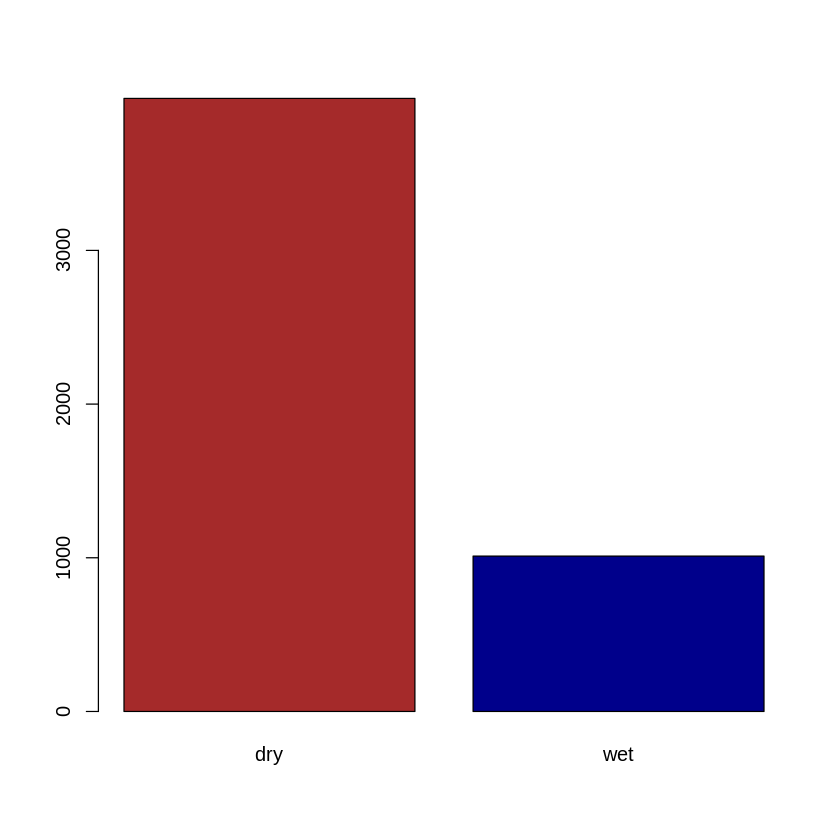

In [11]:
#::GMG::Se me ha ocurrido que puede ser interesante ver la proporción de clases en el dataset
#::nota::considero '0' días secos (dry) y '1' días lluviosos (wet)
#::nota::un 'imbalanced' dataset suele ser 'problemático' para la clasificación
#::nota::la clase 'dry' está sobre-representada en el dataset
table(occurrence)
barplot(height = table(occurrence),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))


   0    1 
2994  756 

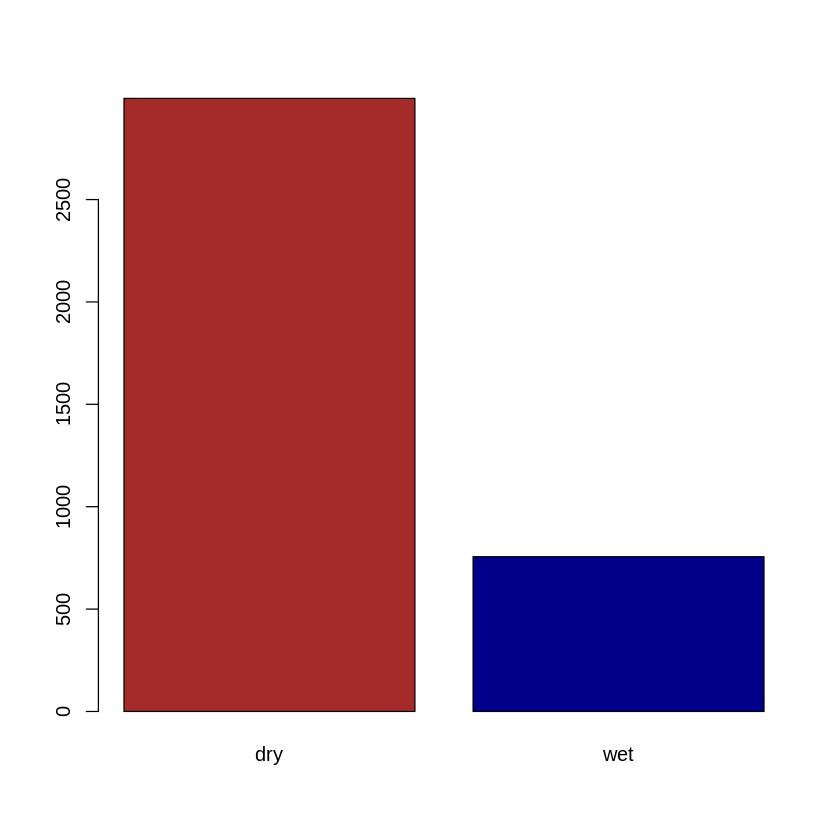

In [12]:
#::GMG::Al hacer la selección train/set puede ser interesante ver la representación
#       de las clases tras hacer la partición
#::nota::estoy puede que tenga que tenerlo en cuenta luego en los resultados de la
#        clasificación y en la validación
table(occurrence[indtrain])
barplot(height = table(occurrence[indtrain]),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))


  0   1 
995 255 

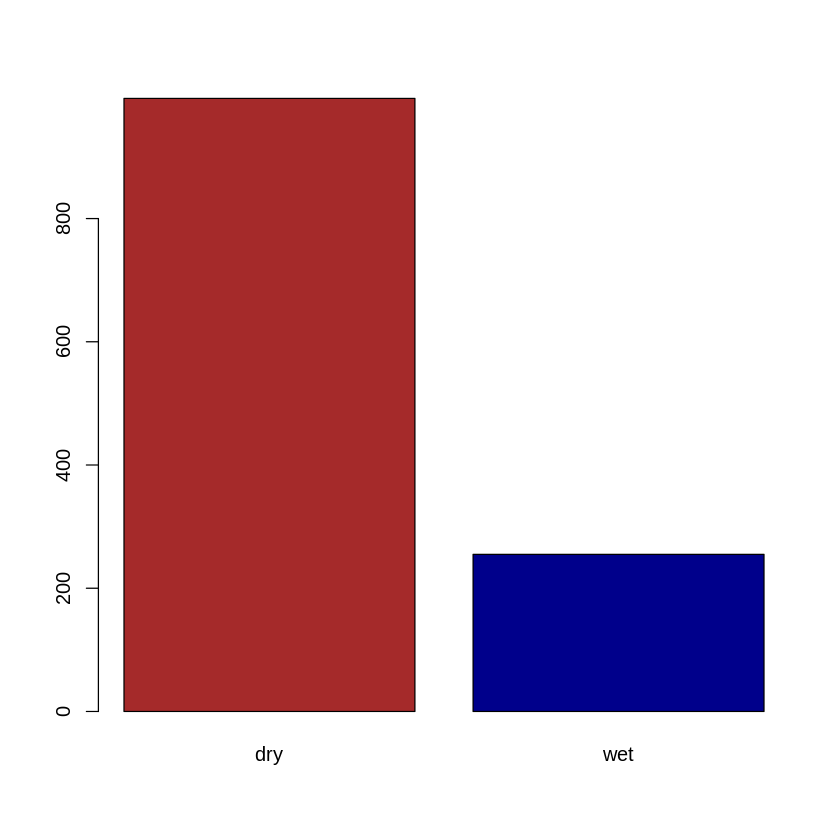

In [13]:
#::GMG::Hago lo mismo para el conjunto de test
#::nota::se ve que se mantiene la proporción del conjunto original en ambos casos
table(occurrence[indtest])
barplot(height = table(occurrence[indtest]),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))

In [14]:
#::GMG::Monto el data.frame de ocurrencia de precipitación (lluvia/no lluvia)
# dataframe for occurrence
df_occ <- cbind(occurrence,x)
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: num  1 0 1 0 0 1 1 0 0 0 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 54125 54110 52486 53065 

In [15]:
#::GMG::Convierto la ocurrencia en un factor con dos niveles 
#::nota::clase binaria para el problema de clasificación
df_occ$occurrence <- as.factor(df_occ$occurrence)
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

#### Árbol Completo

A continuación construiremos el árbol completo (usa la función *tree*).

**::GMG::** ¿Árbol completo? Es un árbol que clasifica perfectamente la muestra de entrenamiento (sobre el que haremos posteriormente un podado, i.e post-pruning) (s32 Overfitting: pruning the tree, presentación S07_ClassificationTrees)

**Nota**: según la documentación de [`tree.control`](https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree.control):

> To produce a tree that fits the data perfectly, set `mindev = 0` and `minsize = 2`, if the limit on tree depth allows such a tree.

In [16]:
#::GMG::Cargo la biblioteca tree by Brian Ripley
# https://cran.r-project.org/web/packages/tree/index.html
library(tree)

In [17]:
#::GMG::Complete tree (tree)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree.control
tree_occ_cp <- tree(occurrence ~ ., 
                   subset= indtrain,
                   data = df_occ, mindev = 0, minsize = 2)

In [18]:
#::GMG::Veo el sumario: 
#       variables usadas, número de hojas, mean dev, error rate
summary(tree_occ_cp)


Classification tree:
tree(formula = occurrence ~ ., data = df_occ, subset = indtrain, 
    mindev = 0, minsize = 2)
Variables actually used in tree construction:
 [1] "X284" "X290" "X283" "X12"  "X8"   "X1"   "X125" "X300" "X295" "X305"
[11] "X294" "X13"  "X83"  "X20"  "X304" "X84"  "X5"   "X2"   "X3"   "X285"
[21] "X24"  "X4"   "X310" "X25"  "X88"  "X6"   "X15"  "X299" "X10"  "X85" 
[31] "X18"  "X89"  "X19"  "X289" "X14"  "X7"  
Number of terminal nodes:  280 
Residual mean deviance:  0 = 0 / 3470 
Misclassification error rate: 0 = 0 / 3750 

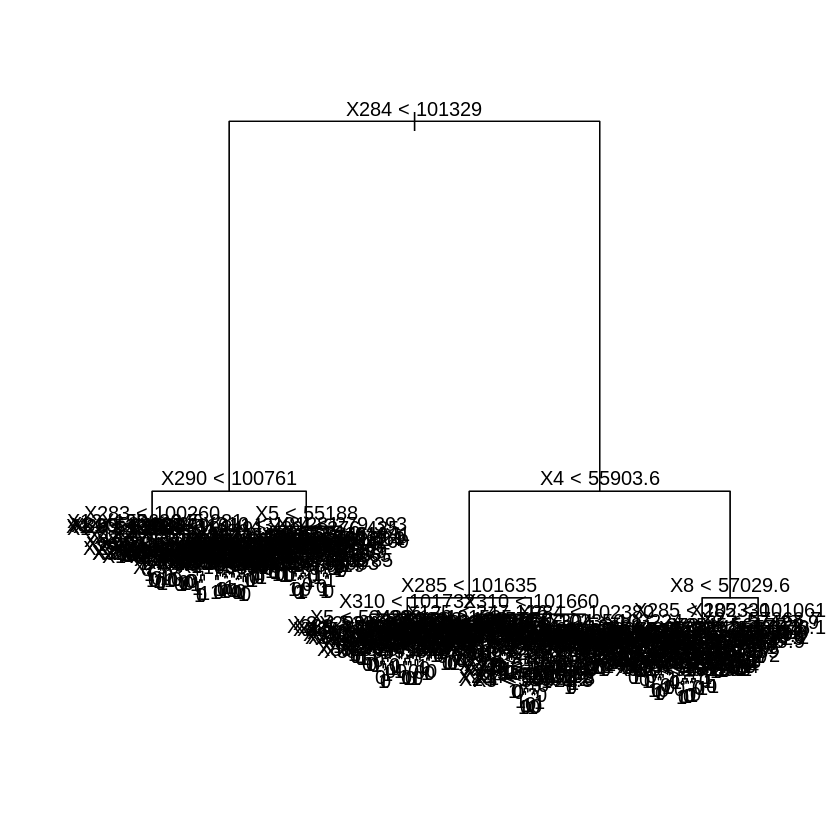

In [19]:
plot(tree_occ_cp)
text(tree_occ_cp, pretty = F)

**P1:** ¿Cuántos nodos terminales obtienes? 

In [20]:
#::GMG::count terminal nodes
# https://stackoverflow.com/questions/53208273/how-to-count-nodes-in-a-tree-in-r
paste('El número de nodos terminales es:', length(unique(tree_occ_cp$where)))

[1] "El número de nodos terminales es: 280"

**P2:** ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

**::GMG::** `X283`, `X284`, `X285`, `X290`, `X310` y `X4`, `X5`, `X8`. Según la descripción del dataset son los valores de "*Presión al nivel del mar*" en cinco localizaciones y  "*Altura geopotencial en 500 hPa*" en tres localizaciones, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)

#### 10-fold CV y podado a posteriori

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [21]:
#::GMG::Hago CV reproducible
set.seed(123)

In [22]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_occ <- cv.tree(object = tree_occ_cp, FUN = prune.misclass, K = 10)

In [23]:
#::GMG::Datos que puedo ver del resultado de la Cross-validation
names(cv_occ)

[1] "size"   "dev"    "k"      "method"

In [24]:
#::GMG::Vemos el resultado de la cross-validation
cv_occ

$size
 [1] 280 254 242 238 229 222 162 159 147 135 123 106  57  52  50  45  42  28  20
[20]  17  11   9   8   5   4   2   1

$dev
 [1] 561 561 561 561 561 561 560 560 560 560 560 560 560 560 560 560 560 560 560
[20] 560 560 553 554 553 551 552 756

$k
 [1]        -Inf   0.5000000   0.6666667   0.7500000   0.7777778   0.8571429
 [7]   1.0000000   1.3333333   1.5000000   1.6666667   1.7500000   1.9411765
[13]   2.0000000   2.4000000   2.5000000   2.6000000   2.6666667   2.7142857
[19]   3.0000000   4.0000000   4.6666667   5.5000000   7.0000000   8.0000000
[25]  15.0000000  23.0000000 222.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

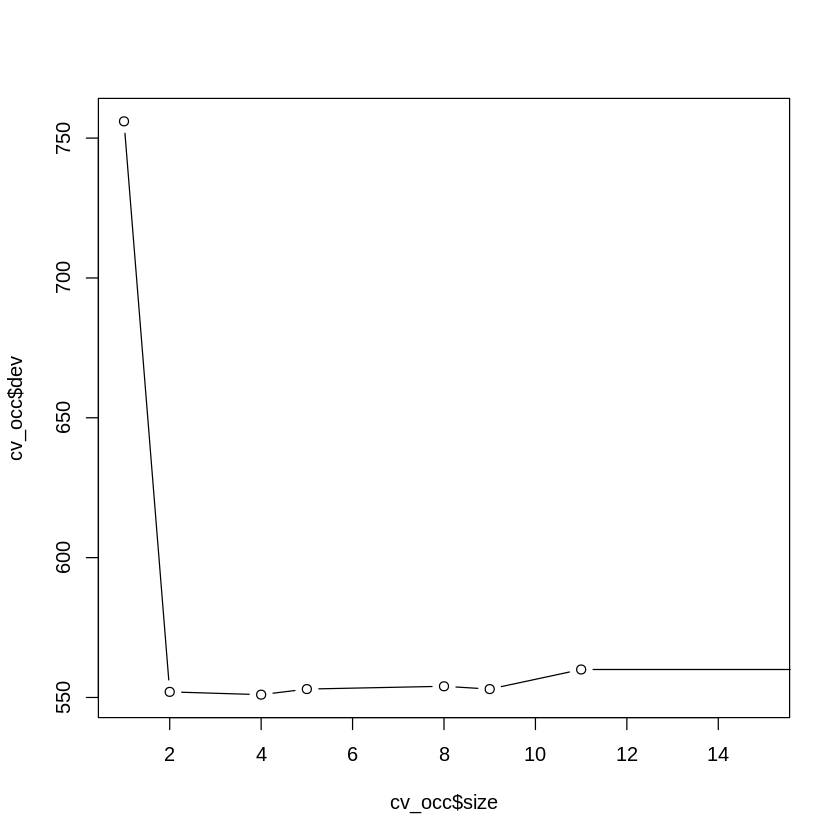

In [313]:
#::GMG::Lo veo en forma gráfica concentrándome en la zona de mínimos
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/plot.tree
# plot(cv_occ, xlim = c(1,10), ylim = c(550,560))
plot(cv_occ$size,cv_occ$dev,type='b', xlim = c(1,15))

In [34]:
paste('El tamaño óptimo de hojas es:', cv_occ$size[which.min(cv_occ$dev)])

[1] "El tamaño óptimo de hojas es: 4"

**::GMG::** De los números que salen en `$size` y `$dev` el rango de [2 10] se tiene un `$dev` muy parecido.

In [38]:
#::GMG:: Ahora lo podo
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/prune.tree
# pruned_tree_occ <- prune.tree(tree_occ_cp, best = 5, method = 'misclass')
pruned_tree_occ <- prune.misclass(tree_occ_cp, best = 4)

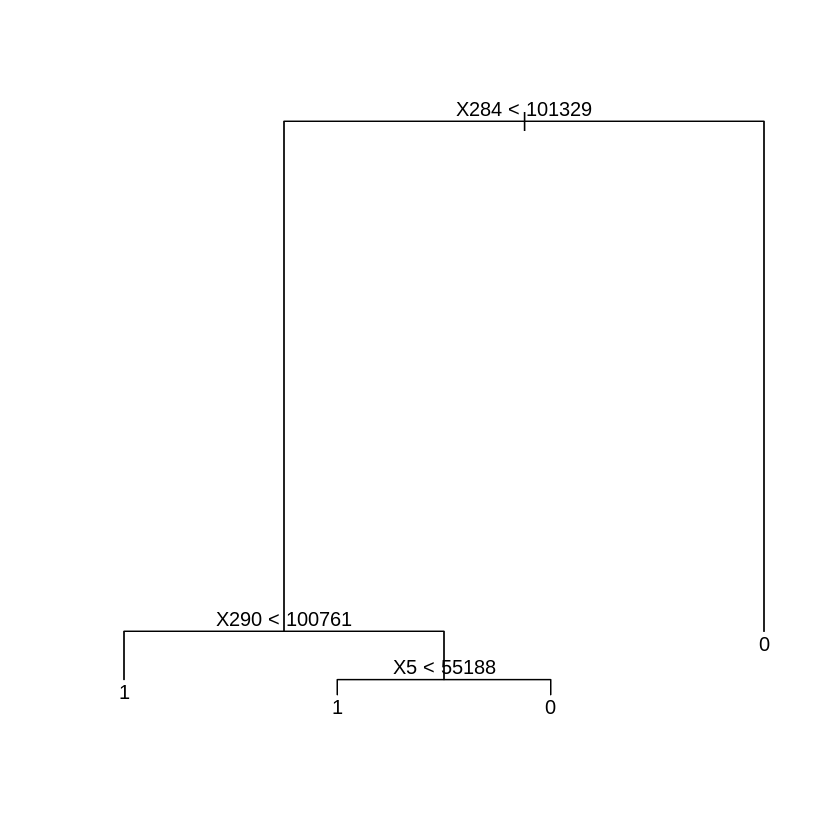

In [39]:
#::GMG::Visualizo el resultado
plot(pruned_tree_occ)
text(pruned_tree_occ, pretty = 0)

In [40]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
#       misclassification error rate, residual mean deviance, ...
summary(pruned_tree_occ)


Classification tree:
snip.tree(tree = tree_occ_cp, nodes = c(4L, 11L, 3L, 10L))
Variables actually used in tree construction:
[1] "X284" "X290" "X5"  
Number of terminal nodes:  4 
Residual mean deviance:  0.7277 = 2726 / 3746 
Misclassification error rate: 0.1301 = 488 / 3750 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X284`, `X290`, `X5`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en dos localizaciones y  "Altura geopotencial en 500 hPa" en una localización, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

In [44]:
#::GMG::Hago la predicción para el conjunto de test (occurrence prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_occ <- predict(object = pruned_tree_occ, newdata = df_occ[indtest,], type="class")

In [45]:
str(pred_occ)

 Factor w/ 2 levels "0","1": 1 1 2 2 2 2 2 2 2 2 ...


In [99]:
#::GMG::Además de guardar la predicción puedo ver cómo es esa predicción
#       en términos de la tabla de contingencia
### Confusion Matrix to check number of Misclassifications ###
t_occ <- with(df_occ[indtest,],table(pred_occ,occurrence))
print(t_occ)

        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


In [51]:
## Misclassification Error Rate on Test Set ##
error_occ <- mean(pred_occ != df_occ[indtest,]$occurrence)
paste('Misclassification Error Rate (Test):', 100*error_occ, '%')

[1] "Misclassification Error Rate (Test): 15.6 %"

In [52]:
## Accuracy on Test Set (1 - Misclassification error rate) ##
accuracy_occ <- sum(
    diag(table(pred_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('Accuracy (Test):', 100*accuracy_occ, '%')

[1] "Accuracy (Test): 84.4 %"

In [308]:
#::GMG::Me pregunto si estoy en zona de overfitting o underfitting
#       Hago una pequeña exploración de árboles dentro de la 'zona del óptimo'
#       que deduce con el podado con CV
#       (mejor con random forest, claro :)
acc_train <- c()
acc_test <- c()
for (size in 2:15) {
    t <- prune.misclass(tree_occ_cp, best = size)
    p_train <- predict(object = t, newdata = df_occ[indtrain,], type="class")
    acc_train[size] <- sum(
                            diag(table(p_train,df_occ[indtrain,]$occurrence))
                          )/length(df_occ[indtrain,]$occurrence)
    p_test <- predict(object = t, newdata = df_occ[indtest,], type="class")
    acc_test[size] <- sum(
                            diag(table(p_test,df_occ[indtest,]$occurrence))
                          )/length(df_occ[indtest,]$occurrence)
}

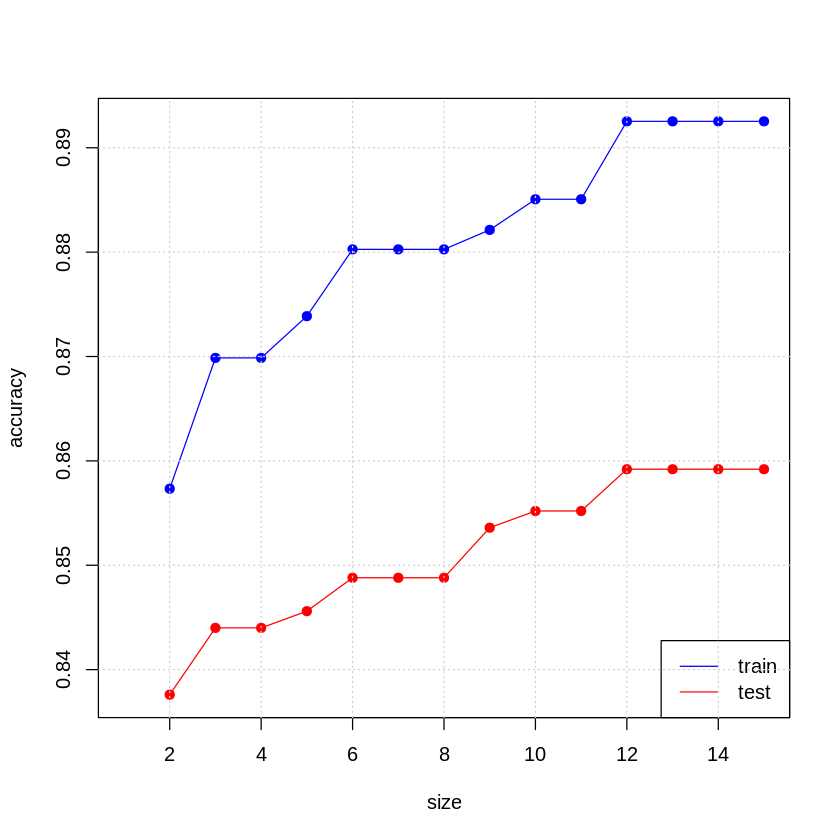

In [312]:
#::GMG::Dibujo el resultado
#par(mfrow = c(1,2))
matplot(cbind(acc_train, acc_test), 
        type = "o", pch = 19, lty = 1, 
        col = c("blue", "red"),
xlab = "size", ylab = "accuracy")
legend("bottomright", c("train", "test"),
       lty = 1, 
       col = c("blue", "red")
      )
grid()
#::GMG::Dibujo el resultado también con error
#matplot(cbind(1 - acc_train, 1 - acc_test), 
#        type = "o", pch = 19, lty = 1, 
#        col = c("blue", "red"),
#xlab = "size", ylab = "misclassification error")
#legend("bottomleft", c("train", "test"),
#       lty = 1, 
#       col = c("blue", "red")
#      )
#grid()

**::GMG::** Parece que 12 es el tamaño a partir de cual ya no hay mejora. La mejora de 4 a 12 no es muy grande, apenas un 2%. Mantengo mi árbol de tamaño 4.

### Regresión CART

#### Intensidad

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

In [53]:
#::GMG::Monto el dataset para amount
## dataframe for amount
#::nota::mantengo los índices de train/test
df_amount <- cbind(y,x)
str(df_amount)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). 

#### Árbol Completo en todo el conjunto de train

Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

In [54]:
#::GMG::Construyo el árbol completo sobre todo el train (llueva o no)
## complete tree 1
#::nota::recordar lo que dice la documentación de tree.control para
#        poner bien los parámetros
tree_amount_all_cp <- tree(y ~ ., 
                   subset= indtrain,
                   data = df_amount, mindev = 0, minsize = 2)

In [55]:
summary(tree_amount_all_cp)


Regression tree:
tree(formula = y ~ ., data = df_amount, subset = indtrain, mindev = 0, 
    minsize = 2)
Number of terminal nodes:  922 
Residual mean deviance:  0.003691 = 10.44 / 2828 
Distribution of residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2667000 -0.0033330 -0.0006983  0.0000000  0.0000000  0.3000000 

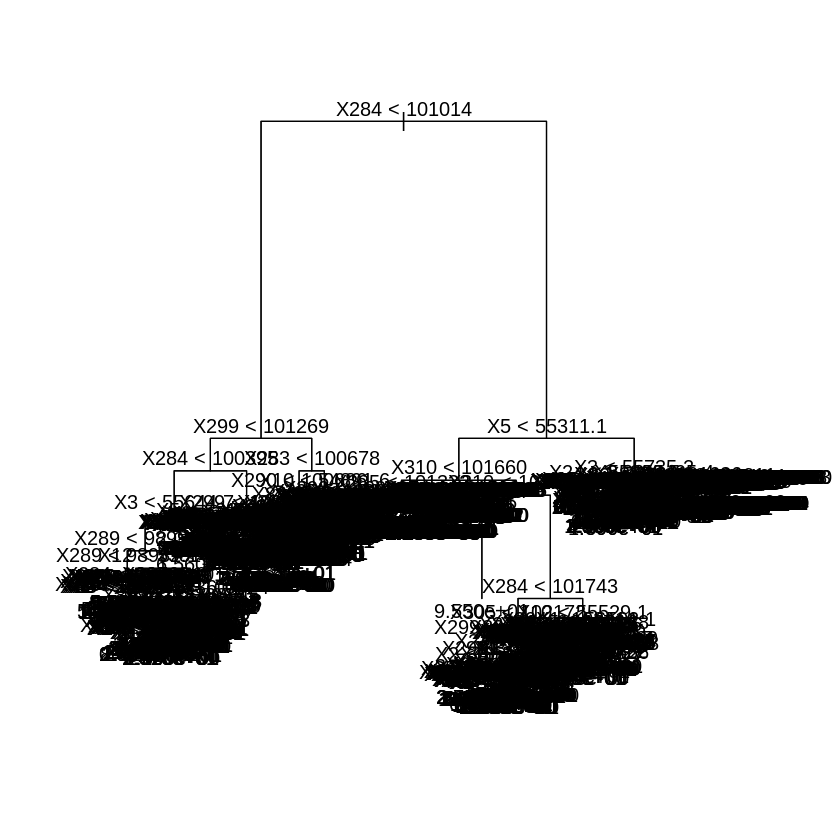

In [56]:
plot(tree_amount_all_cp)
text(tree_amount_all_cp, pretty = F)

In [57]:
paste('El número de nodos terminales es:', length(unique(tree_amount_all_cp$where)))

[1] "El número de nodos terminales es: 922"

**::GMG::** Las primeras subdivisiones del árbol usan las siguientes variables predictoras: X284, X289, X299, X310 y X3, X5. Según la descripción del dataset son los valores de "Presión al nivel del mar" en cuatro localizaciones y  "Altura geopotencial en 500 hPa" en dos localizaciones, respectivamente. Parece que se ha dado más "peso" a la *presión a nivel del mar* en este caso.

**::nota::**:

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### 10-fold CV y podado a posteriori

Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [58]:
#::GMG::Hago CV reproducible
set.seed(123)

In [59]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_amount <- cv.tree(object = tree_amount_all_cp, FUN = prune.tree, K = 10)

In [60]:
paste('El tamaño óptimo de hojas es:', cv_amount$size[which.min(cv_amount$dev)])

[1] "El tamaño óptimo de hojas es: 7"

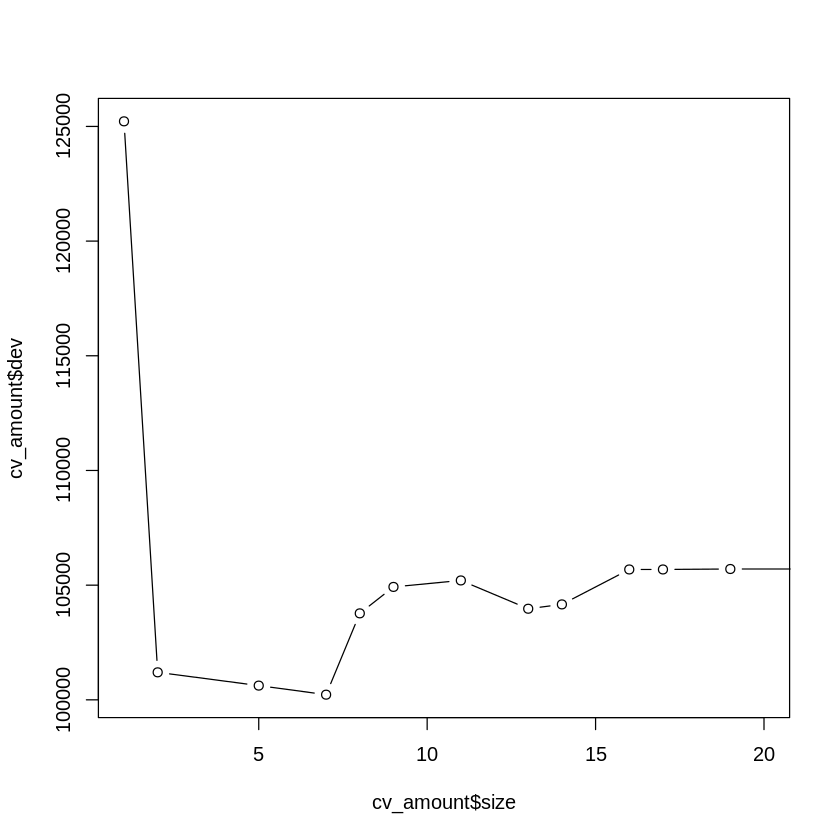

In [62]:
#::GMG::Lo veo gráficamente
#plot(cv_amount, xlim =c(1,20) , ylim = c(100000, 105000))
plot(cv_amount$size,cv_amount$dev,type='b', xlim =c(1,20))

In [63]:
#::GMG:: Ahora lo podo con el 'mejor' tamaño elegido por CV
pruned_tree_amount_all <- prune.tree(tree_amount_all_cp, best = 7)

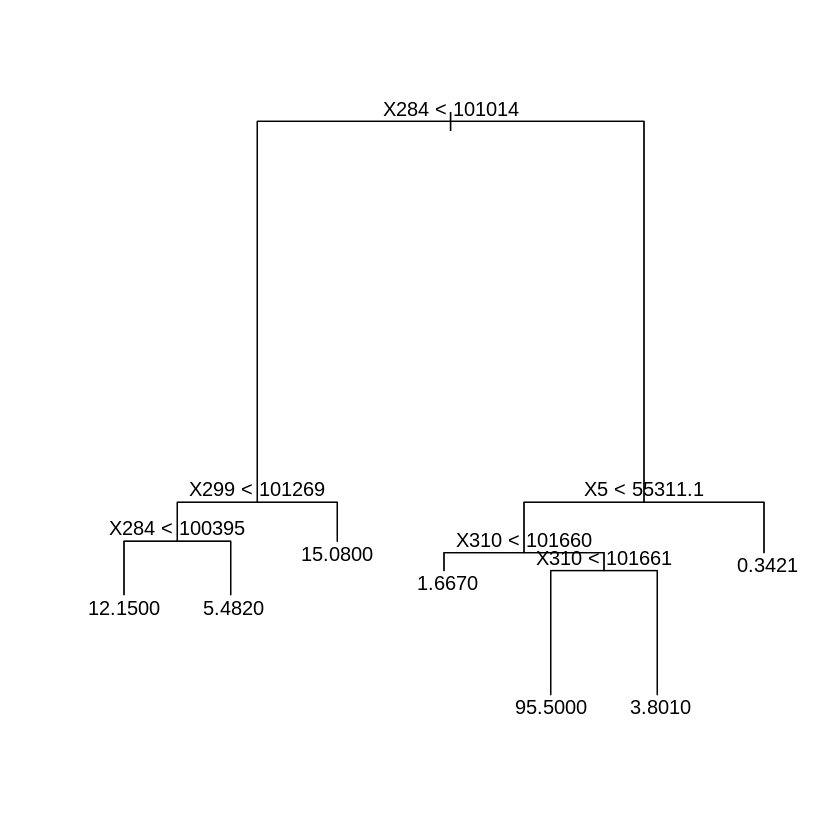

In [64]:
#::GMG::Visualizo el resultado
plot(pruned_tree_amount_all)
text(pruned_tree_amount_all, pretty = 0)

In [65]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_amount_all)


Regression tree:
snip.tree(tree = tree_amount_all_cp, nodes = c(12L, 7L, 9L, 5L, 
27L, 8L))
Variables actually used in tree construction:
[1] "X284" "X299" "X5"   "X310"
Number of terminal nodes:  7 
Residual mean deviance:  21.41 = 80150 / 3743 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-15.0800  -0.3421  -0.3421   0.0000  -0.3421  53.4500 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X310`, `X284`, `X299`, `X5`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en tres localizaciones (se ha caído una tras la poda) y  "Altura geopotencial en 500 hPa" en una localización (se ha caído una tras la poda), respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.

In [66]:
#::GMG::Hago la predicción para el conjunto de test (amount prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_amount <- predict(object = pruned_tree_amount_all, 
                       newdata = df_amount[indtest,])

In [67]:
str(pred_amount)

 Named num [1:1250] 1.667 0.342 12.154 5.482 5.482 ...
 - attr(*, "names")= chr [1:1250] "1" "7" "19" "24" ...


In [213]:
#::GMG::Calculo métricas de error para discusión posterior
#::nota::hay dudas sobre el valor e R2 para valorar el goodness of fit y el (R)MSE
# https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/10/lecture-10.pdf
#SSE_amount_all <- sum((df_amount$y[indtest] - pred_amount)^2)
#SST_amount_all <- sum((df_amount$y[indtest] - mean(df_amount$y[indtest]))^2)
RMSE_amount_all <- sqrt(mean((df_amount$y[indtest] - pred_amount)^2))
#R2_amount_all <- 1 - SSE_amount_all/SST_amount_all
paste('RMSE (Test):', round(RMSE_amount_all,2)#,
      #'// R2 (Test):', round(R2_amount_all,2)
     )

[1] "RMSE (Test): 5.42"

In [224]:
#::GMG::Caculo de la correlación entre predicción y muestra
cor_amount_all <- cor(pred_amount, df_amount$y[indtest], method='spearman')
paste('Spearman:', round(cor_amount_all,2))

[1] "Spearman: 0.54"

In [260]:
#::GMG::Métrica de ratio de varianzas
rv_amount_all <- var(pred_amount) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_amount_all,2))

[1] "Ratio Varianzas: 0.54"

In [261]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_amount_all, cor_amount_all, rv_amount_all)

RMSE_amount_all,cor_amount_all,rv_amount_all
5.424795,0.5357675,0.5403199


#### Árbol completo solo días de lluvia

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

In [343]:
#::GMG::Ahora voy a usar solamente los días de lluvia
#::nota::Aquí considero df_rainy como un subconjunto de df_amount y luego
#        hago una nueva partición train/test para entrenar un árbol óptimo con cv
#::DUDA::El problema con esta aproximación es que luego para calcular la 
#        'serie completa' para el test no tiene sentido considerar la ocurrencia
#        porque el tamaño de los datasets va a ser diferente (se han quitado los 
#        ceros, es decir, los días secos)
#rainy <- y*occurrence
#rain <- rainy[-which(rainy == 0)]
#df_rainy <- cbind(rain, x[which(occurrence == 1),])
#str(df_rainy)
#::GMG::Hago train/test reproducible
#set.seed(123)
#::GMG::Hago la NUEVA partición Train/Test para Cross-Validation
# train/test partition
#::nota::ya no tenemos 5000 samples ... tenemos 1011 ;)
#indtrain_rainy <- sample(1:nrow(df_rainy), round(0.75*nrow(df_rainy)))  
#indtest_rainy <- setdiff(1:nrow(df_rainy), indtrain)
#::nota::Lo que decido hacer es interpretar literalmente el enunciado
#        'el que sólo se entrena sobre los días de lluvia en el train'
# https://stackoverflow.com/questions/4935479/how-to-combine-multiple-conditions-to-subset-a-data-frame-using-or
# nrow((df_amount[indtrain,])[which(df_amount$y[indtrain] >= 1),])
nrow(subset(df_amount[indtrain,], df_amount$y[indtrain] >= 1))

[1] 756

In [342]:
#::GMG::Repito el proceso de 'refinado' de árbol completo
## complete tree 2 (trained only on rainy days)
tree_amount_rainy_cp <- tree(y ~ ., 
                   subset = df_amount$y[indtrain] >= 1,
                   data = df_amount[indtrain,], 
                   mindev = 0, minsize = 2)

In [344]:
summary(tree_amount_rainy_cp)


Regression tree:
tree(formula = y ~ ., data = df_amount[indtrain, ], subset = df_amount$y[indtrain] >= 
    1, mindev = 0, minsize = 2)
Number of terminal nodes:  593 
Residual mean deviance:  0.01767 = 2.88 / 163 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.1667  0.0000  0.0000  0.0000  0.0000  0.1800 

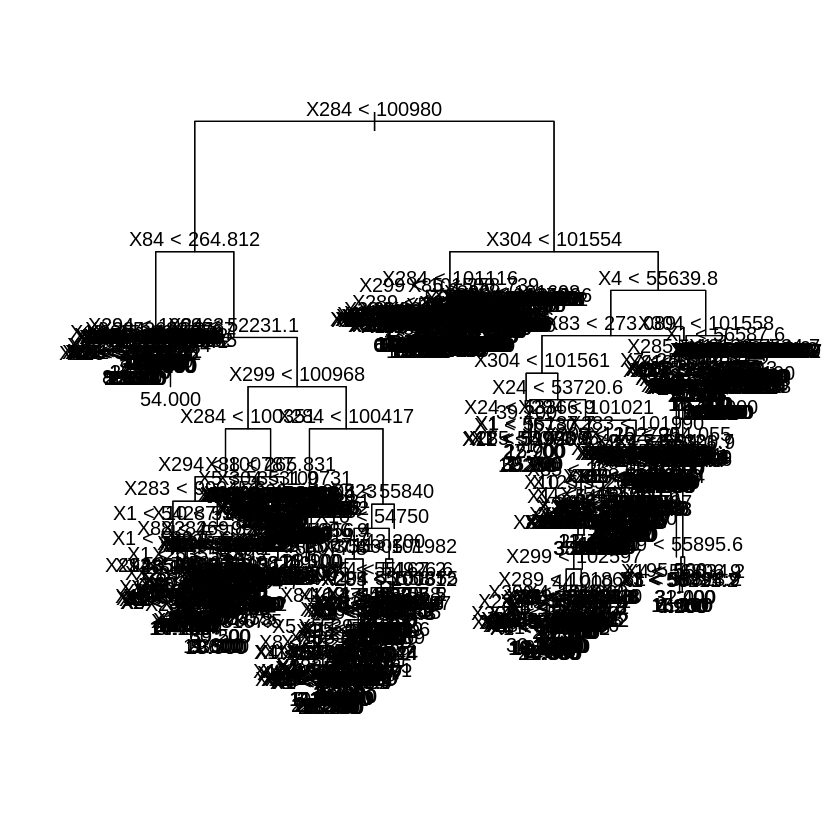

In [345]:
plot(tree_amount_rainy_cp)
text(tree_amount_rainy_cp, pretty = F)

In [346]:
paste('El número de nodos terminales es:', length(unique(tree_amount_rainy_cp$where)))

[1] "El número de nodos terminales es: 593"

#### 10-fold CV y podado a posteriori

In [347]:
#::GMG::Hago CV reproducible
set.seed(123)

In [348]:
## 10-fold cross-validation for determining optimum number of leaves
cv_amount_rainy <- cv.tree(object = tree_amount_rainy_cp, FUN = prune.tree, K = 10)

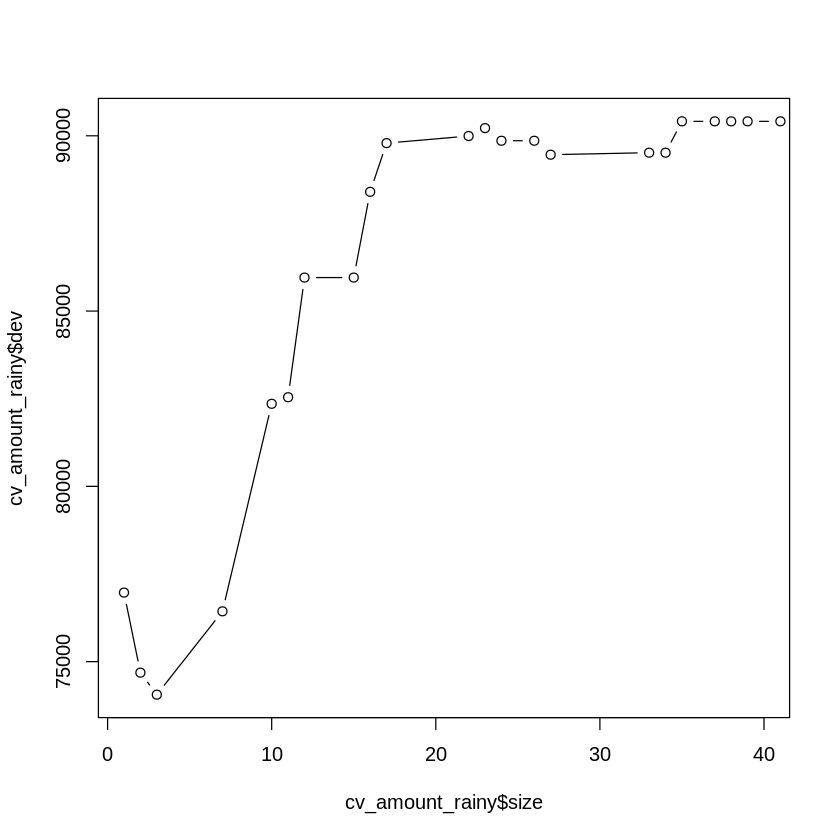

In [349]:
# plot(cv_amount_rainy, xlim = c(1,40))
plot(cv_amount_rainy$size,cv_amount_rainy$dev,type='b', xlim = c(1,40))

In [350]:
paste('El tamaño óptimo de hojas es:', cv_amount_rainy$size[which.min(cv_amount_rainy$dev)])

[1] "El tamaño óptimo de hojas es: 3"

In [351]:
#::GMG:: Ahora lo podo
#::nota::el valor óptimo tal vez sea demasiado "simple" y estemos en "bajoajuste"
pruned_tree_amount_rainy <- prune.tree(tree_amount_rainy_cp, best = 3)

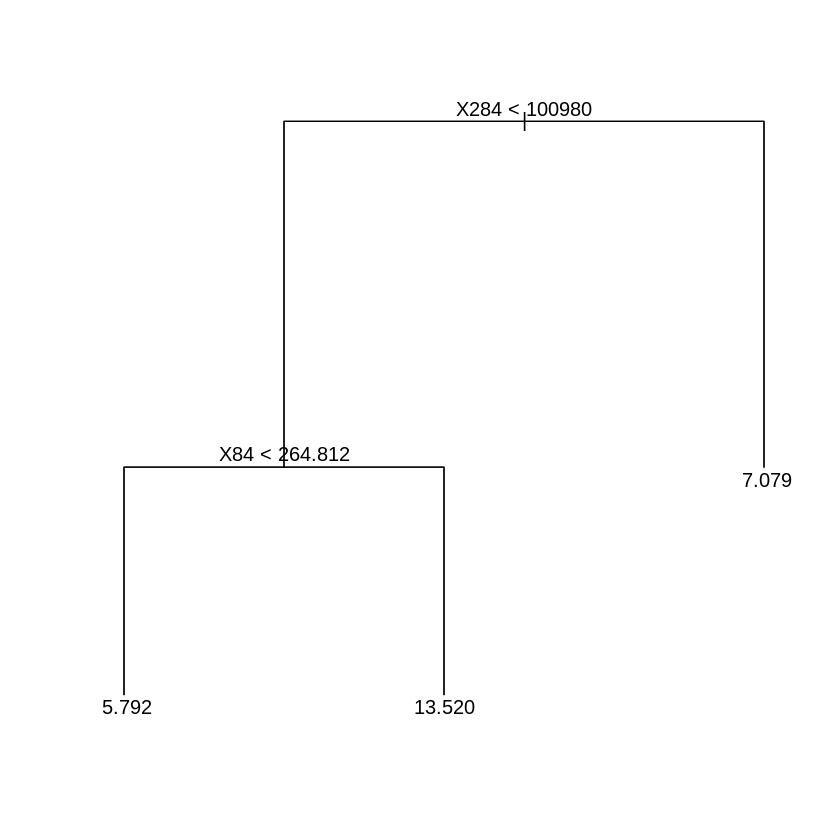

In [352]:
#::GMG::Visualizo el resultado
plot(pruned_tree_amount_rainy)
text(pruned_tree_amount_rainy, pretty = 0)

In [353]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_amount_rainy)


Regression tree:
snip.tree(tree = tree_amount_rainy_cp, nodes = c(4L, 5L, 3L))
Variables actually used in tree construction:
[1] "X284" "X84" 
Number of terminal nodes:  3 
Residual mean deviance:  91.56 = 68950 / 753 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-12.520  -5.479  -2.849   0.000   2.688  88.420 

#### Predicción (test)

In [354]:
#::GMG::Hago la predicción
## amount prediction for test
#pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
#                             newdata = df_rainy[indtest_rainy,])
#::nota::ahora supongo que se refiere al test del conjunto completo y no 
#        al subconjunto del conjunto de test que solamente tiene días
#        de lluvia
#::DUDA::No sé si esto es correcto pero es la única manera de obtener
#        luego en la validación una 'serie completa' combinandola con la
#        serie de ocurrencia
#pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
#                             newdata = subset(df_amount[indtest,], df_amount$y[indtest] >= 1)
#                             )
pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
                             newdata = df_amount[indtest,])

In [355]:
#::GMG::Calculo métricas de error para discusión posterior
#RMSE_amount_rainy <- sqrt(mean((df_rainy$rain[indtest_rainy] - pred_amount_rainy)^2))
RMSE_amount_rainy <- sqrt(mean((df_amount$y[indtest] - pred_amount_rainy)^2))
paste('Solo lluvia RMSE (Test):', round(RMSE_amount_rainy,2))

[1] "Solo lluvia RMSE (Test): 7.58"

In [358]:
#cor_amount_rainy <- cor(pred_amount_rainy, df_rainy$rain[indtest_rainy], method = 'spearman')
cor_amount_rainy <- cor(df_amount$y[indtest], pred_amount_rainy,  method = 'spearman')
paste('Solo lluvia Spearman:', round(cor_amount_rainy,2))

[1] "Solo lluvia Spearman: 0.29"

In [357]:
#::GMG::Métrica de ratio de varianzas
#::DUDA::aquí se aprecia un 'underfit' (?)
rv_amount_rainy <- var(pred_amount_rainy) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_amount_rainy,2))

[1] "Ratio Varianzas: 0.11"

In [359]:
#::GMG::Resumen Test dataset amount solo lluvia óptimo
cbind(RMSE_amount_rainy, cor_amount_rainy, rv_amount_rainy)

RMSE_amount_rainy,cor_amount_rainy,rv_amount_rainy
7.577443,0.2901627,0.1147951


In [360]:
#::GMG::Pruebo un árbol más complejo del siguiente mínimo local en size
pruned_tree_amount_rainy_b <- prune.tree(tree_amount_rainy_cp, best = 10)
summary(pruned_tree_amount_rainy_b)


Regression tree:
snip.tree(tree = tree_amount_rainy_cp, nodes = c(4L, 6L, 15L, 
28L, 59L, 47L, 46L, 22L))
Variables actually used in tree construction:
[1] "X284" "X84"  "X24"  "X299" "X304" "X4"   "X83"  "X7"  
Number of terminal nodes:  10 
Residual mean deviance:  71.25 = 53150 / 746 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-23.530  -4.396  -2.252   0.000   2.801  51.000 

In [361]:
pred_amount_rainy_b <- predict(object = pruned_tree_amount_rainy_b, 
                                newdata = df_amount[indtest,])

In [362]:
#::GMG::Se aprecia una mejora en el ratio de varianza
RMSE_amount_rainy_b <- sqrt(mean((pred_amount_rainy_b - df_amount$y[indtest])^2))
paste('Solo lluvia Size 10 RMSE (Test):', round(RMSE_amount_rainy_b,2))
cor_amount_rainy_b <- cor(pred_amount_rainy_b, df_amount$y[indtest], method = 'spearman')
paste('Solo lluvia Size 10 Spearman:', round(cor_amount_rainy_b,2))
#::GMG::Métrica de ratio de varianzas
rv_amount_rainy_b <- var(pred_amount_rainy_b) / var(df_amount$y[indtest])
paste('Ratio Varianzas Size 10:', round(rv_amount_rainy_b,2))

[1] "Solo lluvia Size 10 RMSE (Test): 7.32"

[1] "Solo lluvia Size 10 Spearman: 0.21"

[1] "Ratio Varianzas Size 10: 0.51"

In [363]:
#::GMG::Resumen Test dataset amount solo lluvia "siguiente óptimo"
#::nota::me quedo con este árbol :)
cbind(RMSE_amount_rainy_b, cor_amount_rainy_b, rv_amount_rainy_b)

RMSE_amount_rainy_b,cor_amount_rainy_b,rv_amount_rainy_b
7.316613,0.2089672,0.5118578


### Validación

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas: 
* Para la parte binaria lluvia/no lluvia: Accuracy.
* Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.

#### Serie Completa (lluvia/no lluvia)

In [368]:
## final prediction
# https://stackoverflow.com/questions/3418128/how-to-convert-a-factor-to-integer-numeric-without-loss-of-information/
pred_final_cp <- as.numeric(as.character(pred_occ)) * pred_amount

In [370]:
#::GMG::Calculo métricas
RMSE_amount_final <- sqrt(mean((df_amount$y[indtest] - pred_final_cp)^2))
paste('RMSE Final:', round(RMSE_amount_final,2))

cor_amount_final <- cor(df_amount$y[indtest], pred_final_cp,  method = 'spearman')
paste('Spearman Final:', round(cor_amount_final,2))

rv_amount_final <- var(pred_final_cp) / var(df_amount$y[indtest])
paste('Ratio Varianzas Final :', round(rv_amount_final,2))

[1] "RMSE Final: 4.76"

[1] "Spearman Final: 0.53"

[1] "Ratio Varianzas Final : 0.28"

In [371]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_amount_final, cor_amount_final, rv_amount_final)

RMSE_amount_final,cor_amount_final,rv_amount_final
4.763387,0.5286241,0.2841801


#### Serie Completa (Solo lluvia)

In [372]:
pred_final_rainy <-  as.numeric(as.character(pred_occ)) * pred_amount_rainy_b

In [373]:
#::GMG::Calculo métricas
RMSE_final_rainy <- sqrt(mean((df_amount$y[indtest] - pred_final_rainy)^2))
paste('Solo lluvia RMSE (Test):', round(RMSE_final_rainy,2))

cor_final_rainy <- cor(df_amount$y[indtest], pred_final_rainy,  method = 'spearman')
paste('Solo lluvia Spearman:', round(cor_amount_rainy,2))

rv_final_rainy <- var(pred_final_rainy) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_amount_rainy,2))

[1] "Solo lluvia RMSE (Test): 4.88"

[1] "Solo lluvia Spearman: 0.29"

[1] "Ratio Varianzas: 0.11"

In [375]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_final_rainy, cor_final_rainy, rv_final_rainy)

RMSE_final_rainy,cor_final_rainy,rv_final_rainy
4.883607,0.5263696,0.5809775


#### Ocurrencia (Clasificación Lluvia/No Lluvia)

In [100]:
#::GMG::Las predicciones que he obtenido
## final prediction occurrece (lluvia/no lluvia)
str(pred_occ)
print(t_occ)
paste('Occurence Misclassification Error Rate (Test):', 100*error_occ, '%')
paste('Occurrence Accuracy (Test):', 100*accuracy_occ, '%')

 Factor w/ 2 levels "0","1": 1 1 2 2 2 2 2 2 2 2 ...
        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


[1] "Occurence Misclassification Error Rate (Test): 15.6 %"

[1] "Occurrence Accuracy (Test): 84.4 %"

#### Más cosas

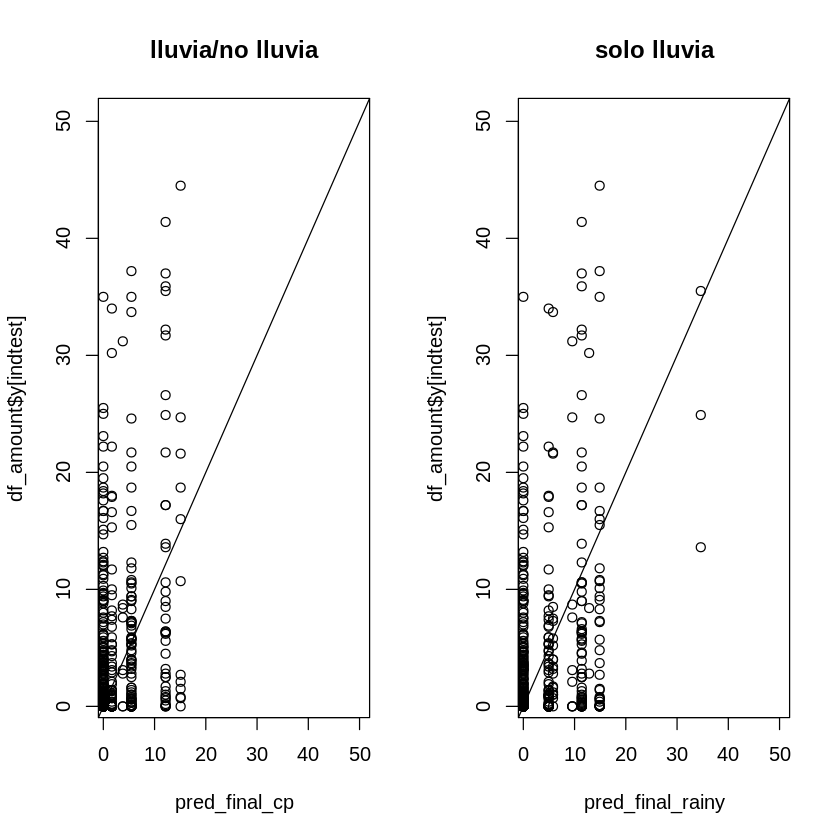

In [381]:
#::GMG::Veo cómo de buena es la predicción gráficamente
par(mfrow = c(1,2))
plot(pred_final_cp,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'lluvia/no lluvia')

abline(0,1)
plot(pred_final_rainy,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'solo lluvia')
abline(0,1)

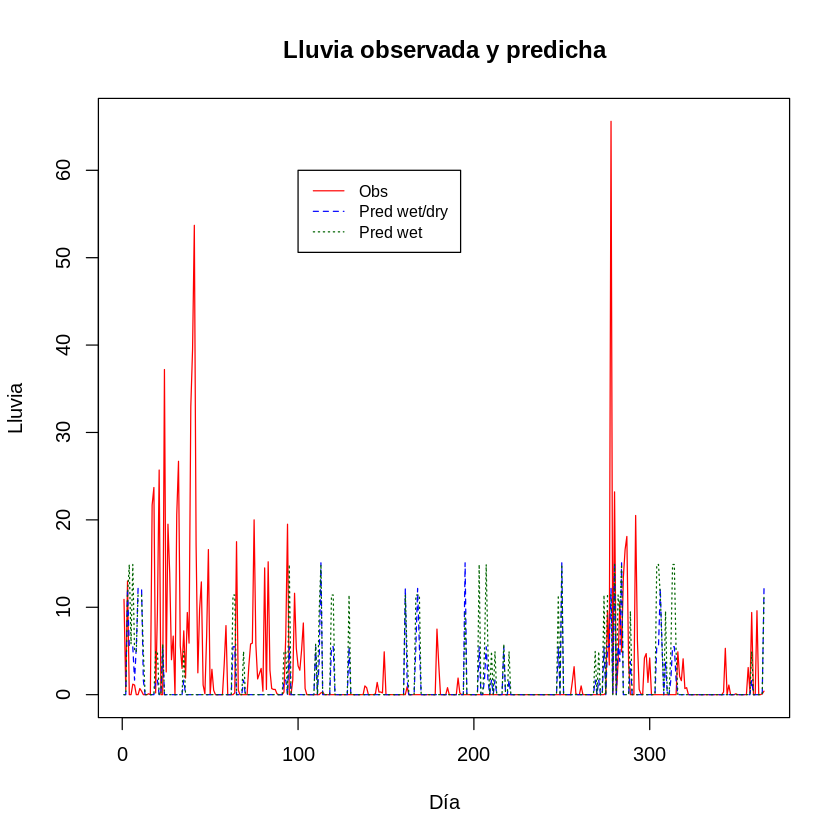

In [383]:
#::GMG::Ejemplo de lluvia observada y predicha (365 primeros días)
plot(df_amount$y[1:365], type = "l",col = "red", 
     xlab = "Día", lty = 1, ylab = "Lluvia", 
     main = "Lluvia observada y predicha")
lines(pred_final_cp[1:365], 
      type = "l", lty = 2, col = "blue")
lines(pred_final_rainy[1:365], 
      type = "l", lty = 3, col = "darkgreen")
legend(100, 60, legend=c("Obs", "Pred wet/dry", "Pred wet"),
       col=c("red", "blue", "darkgreen"), lty=1:3, cex=0.8)

### Conclusiones

**Pregunta:** ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

# Punto 2: Random forests
### (2.5 puntos)

### Clasificación RF

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests. 
Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función *randomForest*) y plotea los errores Out-Of-Bag (OOB). ¿Con cuántos árboles te quedarías?

**Nota:** Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En esta práctica/tarea utlizaremos los valores típicos; *sqrt(n)* en problemas de clasificación y *n/3* en problemas de predicción (siendo *n* el número total de predictores disponibles). 

In [125]:
#::GMG::Cargo la biblioteca necesaria
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14
# https://cran.r-project.org/web/packages/randomForest/index.html
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [127]:
#::GMG::Compruebo que tengo el dataset de occurrencia a mano
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

In [126]:
#::GMG::Hago mi proceso reproducible (la semilla del bosque ;)
#::nota::mantengo el train/test original
set.seed(123)

In [140]:
#::GMG::Hago crecer un bosque de 1000 árboles
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest
#
# ntree Number of trees to grow. This should not be set to too small a number, to ensure 
# that every input row gets predicted at least a few times.
#
#::nota:: estamos en clasificación y pongo mtry = floor(sqrt(ncol(features)))
# mtry Number of variables randomly sampled as candidates at each split. Note that the 
# default values are different for classification (sqrt(p) where p is number of variables 
# in x) and regression (p/3)
#
# RF for occurrence (up to 1000 trees)
bosque_occ <- randomForest(occurrence ~ .,
                           data = df_occ, subset = indtrain,
                           ntree = 1000,
                           mtry = floor(sqrt(ncol(df_occ[,-1])))
                          )

In [141]:
#::GMG::Echo un vistazo al resumen del resultado: OOB, Confusion Matrix
bosque_occ


Call:
 randomForest(formula = occurrence ~ ., data = df_occ, ntree = 1000,      mtry = floor(sqrt(ncol(df_occ[, -1]))), subset = indtrain) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 6

        OOB estimate of  error rate: 12.83%
Confusion matrix:
     0   1 class.error
0 2844 150   0.0501002
1  331 425   0.4378307

In [144]:
#::GMG::Se puede obtener en concreto la matriz de confusión de train
#::nota::la clase menos representada tiene un error rate mucho mayor
print(bosque_occ$confusion)

     0   1 class.error
0 2844 150   0.0501002
1  331 425   0.4378307


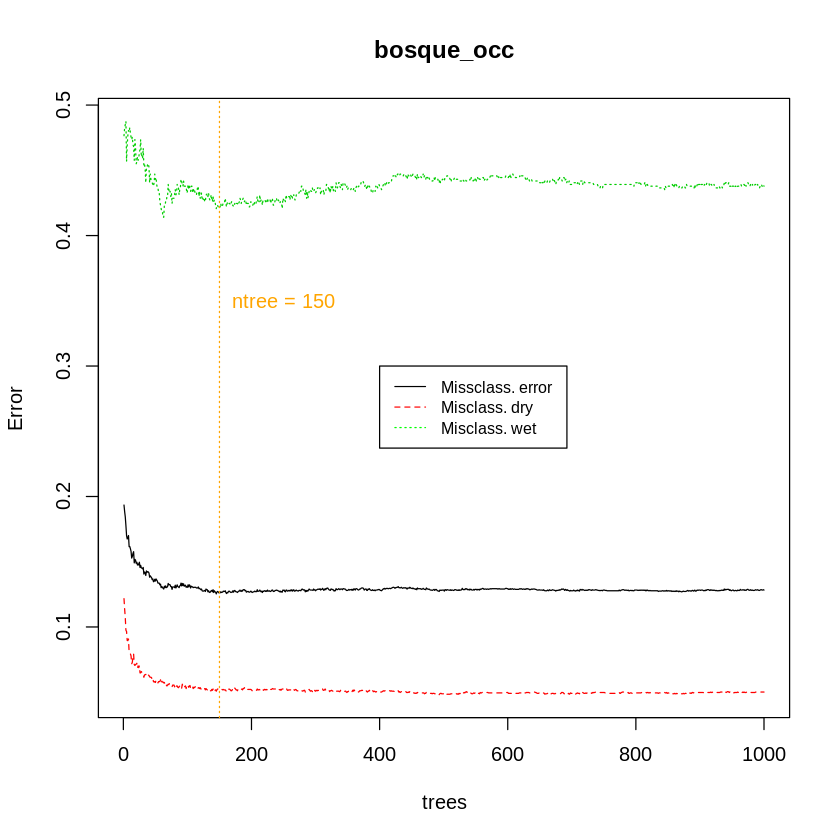

In [175]:
#::GMG::Gráfica OOB
#::nota::supongo que la curva roja es la clase '0' y la verde la clase '1'
#        y la negra es el misclassification error rate total
plot (bosque_occ)
legend(400, 0.3, legend=c("Missclass. error", "Misclass. dry", "Misclass. wet"),
       col=c("black","red", "green"), lty=1:3, cex=0.8)
abline(v = 150, lty = 3, col = 'orange')
text(250,0.35,'ntree = 150', col='orange')

**::GMG::** Parece que después de 150 árboles no se mejora el error ... así que me quedaría con 150

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

In [176]:
#::GMG::Hago el bosque con 100 árboles
## RF for occurrence (optimum)
bosque_occ_opt <- randomForest(
                        occurrence ~ .,
                        data = df_occ, subset = indtrain,
                        ntree = 150,
                        mtry = floor(sqrt(ncol(df_occ[,-1])))
)

In [177]:
print(bosque_occ_opt$confusion)

     0   1 class.error
0 2825 169  0.05644623
1  328 428  0.43386243


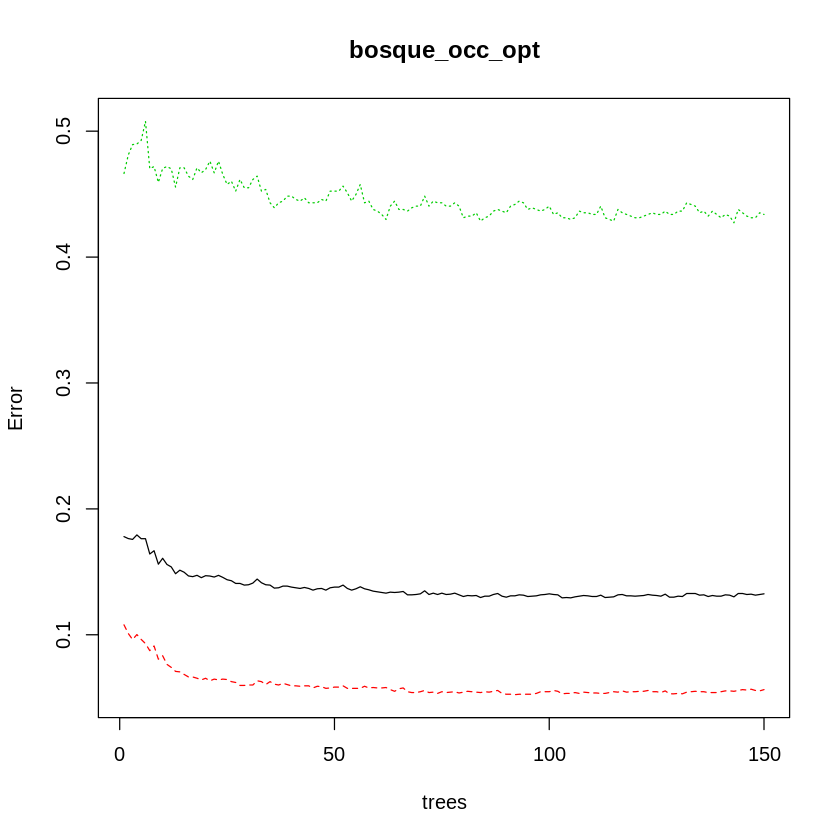

In [178]:
plot (bosque_occ_opt)
legend(400, 0.3, legend=c("Missclass. error", "Misclass. dry", "Misclass. wet"),
       col=c("black","red", "green"), lty=1:3, cex=0.8)

In [179]:
#::GMG::Hago la predicción
## occurrence prediction for test
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/predict.randomForest
#::nota::según la documentación, la puedo hacer en un solo paso con randomForest()
pred_bosque_occ <- predict(object = bosque_occ_opt, 
                           newdata = df_occ[indtest,],
                           type = 'class')

In [180]:
t_bosque_occ <- with(df_occ[indtest,],table(pred_bosque_occ,occurrence))
print(t_bosque_occ)

               occurrence
pred_bosque_occ   0   1
              0 938 113
              1  57 142


In [181]:
error_bosque_occ <- mean(pred_bosque_occ != df_occ[indtest,]$occurrence)
paste('RF Misclassification Error Rate (Test):', 100*error_bosque_occ, '%')

[1] "RF Misclassification Error Rate (Test): 13.6 %"

In [182]:
accuracy_bosque_occ <- sum(
    diag(table(pred_bosque_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('RF Accuracy (Test):', 100*accuracy_bosque_occ, '%')

[1] "RF Accuracy (Test): 86.4 %"

In [157]:
#::GMG::Recuerdo lo que obtuve sin RandomForest
#::nota::realmente la mejora es MUY marginal
print(t_occ)
paste('Occurence Misclassification Error Rate (Test):', 100*error_occ, '%')
paste('Occurrence Accuracy (Test):', 100*accuracy_occ, '%')

        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


[1] "Occurence Misclassification Error Rate (Test): 15.6 %"

[1] "Occurrence Accuracy (Test): 84.4 %"

### Regresión RF

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

#### Dataset Intensidad

In [158]:
## RF 1 for amount (up to 1000 trees)
str(df_amount)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

In [160]:
bosque_amount <- randomForest(
                        y ~ .,
                        data = df_amount, subset = indtrain,
                        ntree = 1000,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [162]:
#::nota:: % var explained es 100 * R2 = 100 *(1 - SSE/SST)
bosque_amount


Call:
 randomForest(formula = y ~ ., data = df_amount, ntree = 1000,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = indtrain) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 24.41447
                    % Var explained: 26.83

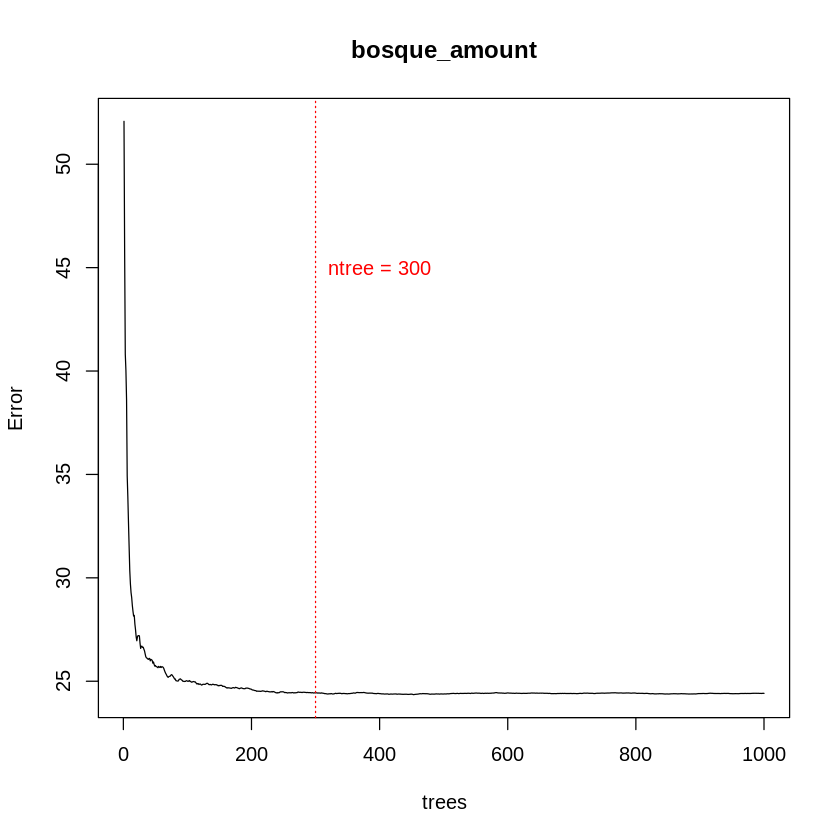

In [172]:
## plotting OOB (MSE) errors 
#::nota::pongo el corte de ntree óptimo
plot(bosque_amount)
abline(v = 300, lty = 3, col = 'red')
text(400,45,'ntree = 300', col='red')

In [167]:
## ntree óptimo
#::nota::Asumo 300 trees
bosque_amount_opt <- randomForest(
                        y ~ .,
                        data = df_amount, subset = indtrain,
                        ntree = 300,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [169]:
bosque_amount_opt


Call:
 randomForest(formula = y ~ ., data = df_amount, ntree = 300,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = indtrain) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 12

          Mean of squared residuals: 24.45213
                    % Var explained: 26.72

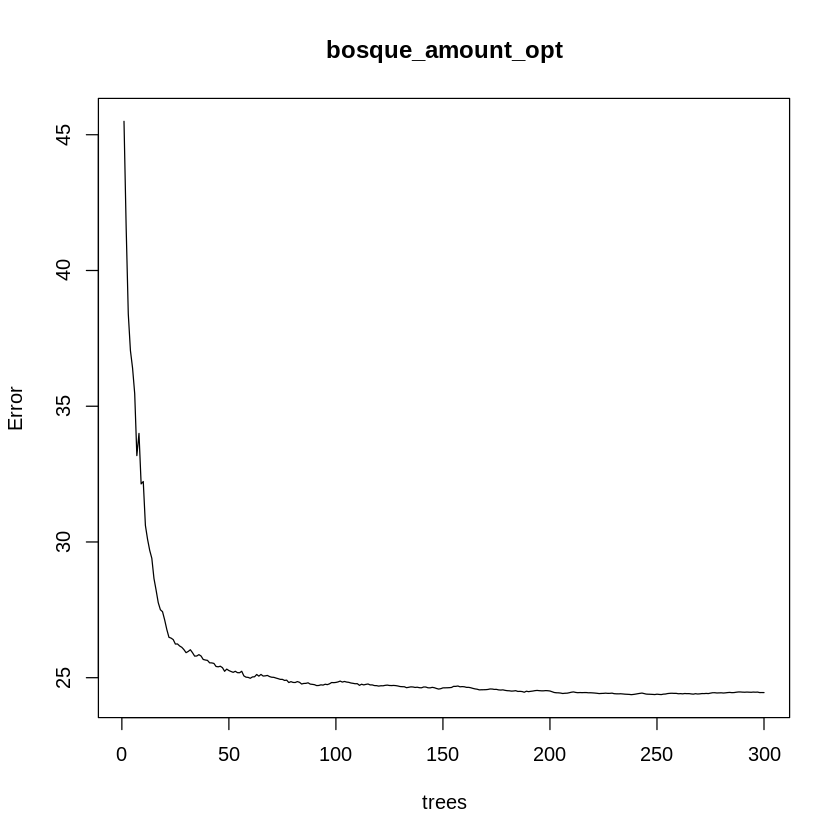

In [168]:
## plotting OOB errors
#::nota::igual se podía recortar un poco más incluso
plot(bosque_amount_opt)

#### Dataset Solo LLuvia

In [183]:
## RF 2 for amount wet only (up to 1000 trees)
str(df_rainy)

'data.frame':	1011 obs. of  38 variables:
 $ rain: num  10.9 13 1.2 1.1 21.7 23.7 9.4 25.7 37.2 2.6 ...
 $ X1  : num  57043 56523 54222 54665 55026 ...
 $ X2  : num  56535 55971 54220 54762 54965 ...
 $ X3  : num  55884 55304 54329 54962 54947 ...
 $ X4  : num  55176 54498 54772 55313 54885 ...
 $ X5  : num  54458 53725 55251 55765 54782 ...
 $ X6  : num  56980 56515 54391 54784 55254 ...
 $ X7  : num  56461 55978 54346 54842 55115 ...
 $ X8  : num  55800 55327 54284 55009 55013 ...
 $ X9  : num  55051 54570 54526 55257 54893 ...
 $ X10 : num  54319 53863 55013 55652 54758 ...
 $ X12 : num  56368 55965 54527 55018 55194 ...
 $ X13 : num  55721 55360 54380 55131 55035 ...
 $ X14 : num  54946 54646 54406 55303 54875 ...
 $ X15 : num  54145 53999 54804 55600 54717 ...
 $ X18 : num  55559 55339 54547 55318 55014 ...
 $ X19 : num  54788 54720 54428 55418 54834 ...
 $ X20 : num  53973 54110 54665 55613 54665 ...
 $ X24 : num  54555 54695 54544 55591 54784 ...
 $ X25 : num  53771 54135 54608 

In [185]:
bosque_amount_rainy <- randomForest(
                        rain ~ .,
                        data = df_rainy, subset = indtrain_rainy,
                        ntree = 1000,
                        mtry = max(floor(ncol(df_rainy[,-1])/3), 1)
)

In [186]:
bosque_amount_rainy


Call:
 randomForest(formula = rain ~ ., data = df_rainy, ntree = 1000,      mtry = max(floor(ncol(df_rainy[, -1])/3), 1), subset = indtrain_rainy) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 79.29851
                    % Var explained: 11.11

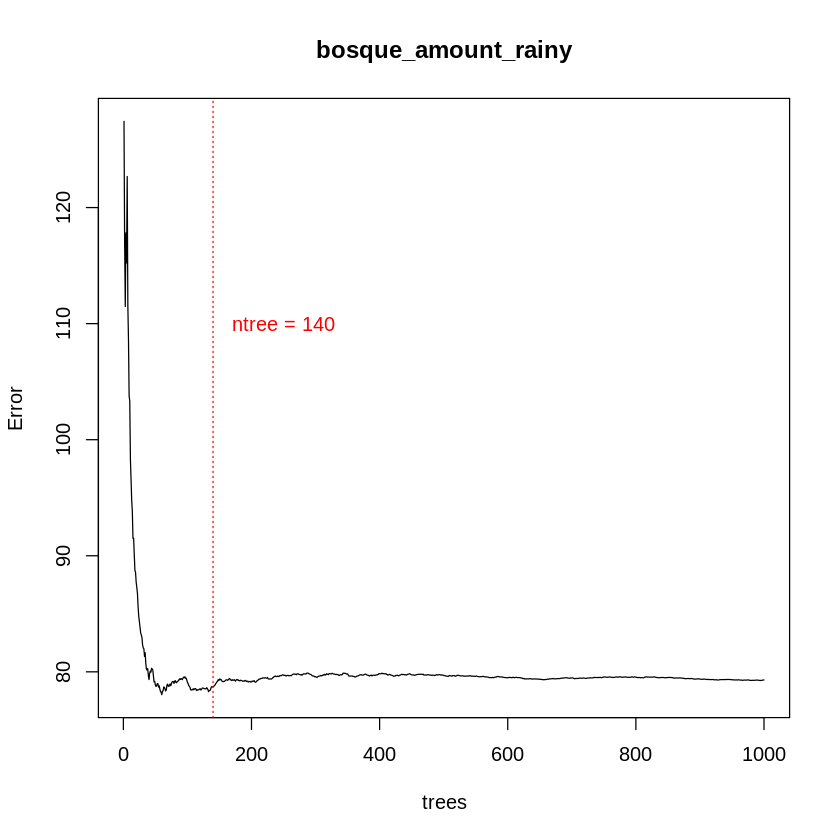

In [200]:
# plotting OOB errors
#::nota::pongo el corte de ntree óptimo
plot(bosque_amount_rainy)
abline(v = 140, lty = 3, col = 'red')
text(250,110,'ntree = 140', col='red')

In [198]:
## ntree óptimo
bosque_amount_rainy_opt <- randomForest(
                        rain ~ .,
                        data = df_rainy, subset = indtrain_rainy,
                        ntree = 140,
                        mtry = max(floor(ncol(df_rainy[,-1])/3), 1)
)

In [199]:
#::nota::el valor % Var explained es MUY bajo (!)
bosque_amount_rainy_opt


Call:
 randomForest(formula = rain ~ ., data = df_rainy, ntree = 140,      mtry = max(floor(ncol(df_rainy[, -1])/3), 1), subset = indtrain_rainy) 
               Type of random forest: regression
                     Number of trees: 140
No. of variables tried at each split: 12

          Mean of squared residuals: 79.57333
                    % Var explained: 10.8

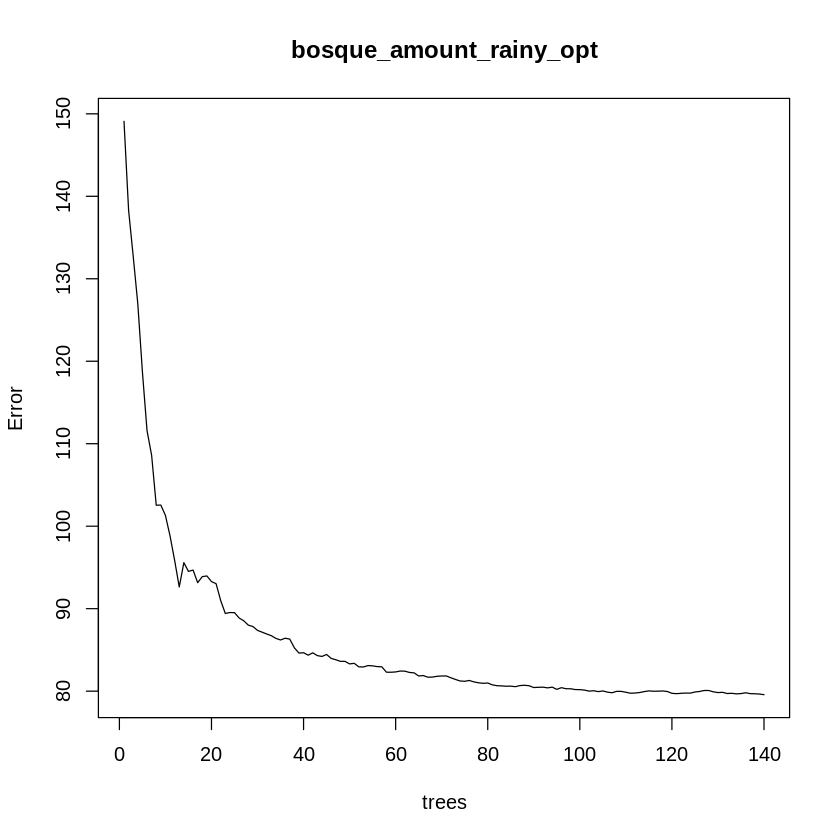

In [201]:
## plotting OOB errors
plot(bosque_amount_rainy_opt)

#### Predicción (Ocurrencia y Solo LLuvia)

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

In [202]:
## amount prediction for test
pred_bosque_amount <- predict(object = bosque_amount_opt, 
                              newdata = df_amount[indtest,])

In [210]:
SSE_bosque_amount <- sum((df_amount$y[indtest] - pred_bosque_amount)^2)
SST_bosque_amount <- sum((df_amount$y[indtest] - mean(df_amount$y[indtest]))^2)
RMSE_bosque_amount <- sqrt(mean((df_amount$y[indtest] - pred_bosque_amount)^2))
R2_bosque_amount <- 1 - SSE_bosque_amount/SST_bosque_amount
paste('RMSE RF (Test):', round(RMSE_bosque_amount,2),
      '// R2 RF (Test):', round(R2_bosque_amount,2)
     )

[1] "RMSE RF (Test): 4.45 // R2 RF (Test): 0.29"

In [207]:
pred_bosque_rainy <- predict(object = bosque_amount_rainy_opt, 
                              newdata = df_rainy[indtest_rainy,])

In [211]:
SSE_bosque_rainy <- sum((df_rainy$rain[indtest_rainy] - pred_bosque_rainy)^2)
SST_bosque_rainy <- sum((df_rainy$rain[indtest_rainy] - mean(df_rainy$rain[indtest_rainy]))^2)
RMSE_bosque_rainy <- sqrt(mean((df_rainy$rain[indtest_rainy] - pred_bosque_rainy)^2))
R2_bosque_rainy <- 1 - SSE_bosque_rainy/SST_bosque_rainy
paste('RMSE RF Rain (Test):', round(RMSE_bosque_rainy,2),
      '// R2 RF Rain (Test):', round(R2_bosque_rainy,2)
     )

[1] "RMSE RF Rain (Test): 5.79 // R2 RF Rain (Test): 0.58"

### Validación

Construye las predicciones completas (ocurrencia * cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

In [ ]:
# predictions for test



In [ ]:
# validation

### Conclusiones

**Pregunta:** Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

## Punto 3: Modelos lineales generalizados (GLMs)
### (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia *binomial* con función de enlace *logit* (regresión logística) para clasificación y la familia *Gamma* con función de enlace *log* para la cantidad. 

Comenzamos con el modelo para la ocurrencia.

In [ ]:
## GLM for occurrence

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

In [ ]:
## occurrence prediction for test

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos). 

In [ ]:
## GLM for amount

Utilizamos el modelo obtenido para predecir la cantidad en el test.

In [ ]:
## amount prediction for test

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

In [ ]:
# final prediction for test

# validation

**Pregunta:** Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

## Punto 4: k nearest neighbors (k-NN)
### (1.5 puntos)

La última de las técnicas a utilizar será la k-NN (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función *knn.reg* del paquete *FNN*). 

**Nota:** Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

In [ ]:
## prediction for test (with k = 1)

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete *caret* para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

In [ ]:
library(caret)
## finding optimum k

Utiliza este *k* óptimo para predecir en el test.

In [ ]:
# prediction for test (with optimum k)

Valida las dos predicciones (con *k=1* y con *k=óptimo*) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

In [ ]:
# validation

**Pregunta:** ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

## Conclusiones generales
### (2 puntos)
A la vista de los resultados obtenidos, argumenta razonadamete qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.